In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MaxAbsScaler

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import joblib

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
df = pd.read_csv("../assets/clean_data.csv", sep=",")
df.head()

In [ ]:
df.info()

In [5]:
df_num = df.select_dtypes(exclude='object')
df_cat = df[['Gender']]

In [7]:
#build pipeline for transform data

#scaling for numeric features
numeric_features = ["Contacts_Count_12_mon","Credit_Limit","Total_Revolving_Bal","Avg_Utilization_Ratio"]
numeric_transformer = StandardScaler()

#one hot encoding for categorical features
categorical_features = ["Gender"]
categorical_transformer = Pipeline(
    steps=
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("scaler", MaxAbsScaler()),  # best for sparse data (or for data already centered at 0)
]

)

preprocessor = ColumnTransformer(
    transformers=
    [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [8]:
#add PCA in pipeline
pca = PCA(n_components=2, random_state=42) 
combined_features = Pipeline([
  ("preprocessor", preprocessor),
  ("pca", pca),
])

In [9]:
#add kmeans in pipeline
n_clusters = 3  # don't worry about setting this; can set to anything and we'll vary it later!
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)
# combine the preprocessor with the clusterer
pipe = Pipeline(
  steps=  
    [
        ("combined", combined_features),
        ("clusterer", clusterer),
    ]
)

In [10]:
pipe

Pipeline(steps=[('combined',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   StandardScaler(),
                                                                   ['Contacts_Count_12_mon',
                                                                    'Credit_Limit',
                                                                    'Total_Revolving_Bal',
                                                                    'Avg_Utilization_Ratio']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore')),
                                                                                   ('scaler',
                                                                                    MaxAbsScaler())]),
                                                                   ['Gender'])])),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3, n_init=50,
                                         random_state=42))]))])

In [11]:
#drop the column of Attrtion_Flag for the model
features = df.drop(['Attrition_Flag'], axis=1)

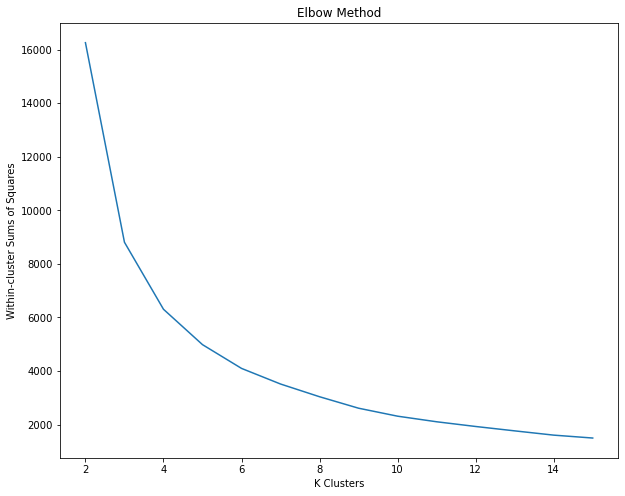

In [13]:
wcss = []

for i in range(2,16):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 42)
    data = pipe['combined'].fit_transform(features)
    km.fit(data)
    wcss.append(km.inertia_)

fig = plt.figure(figsize=(10,8))
plt.plot(range(2,16), wcss)
plt.title('Elbow Method')
plt.xlabel('K Clusters')
plt.ylabel('Within-cluster Sums of Squares')
plt.show()

In [14]:
#based on score, set 3 as the cluster number
pipe = pipe.set_params(clusterer__kmeans__n_clusters=3) 

In [16]:
#got the Silhouette Score, calculate the goodness of a clustering technique. the higher score the better
pipe.fit(features)
preprocessed_data = pipe["combined"].transform(features)
clustered_data = pipe["clusterer"]["kmeans"]
predicted_labels = clustered_data.labels_
score = silhouette_score(preprocessed_data, predicted_labels) 
print('Silhouette Score: ',score)

Silhouette Score:  0.4919767490224015


In [ ]:
#save pipeline
joblib.dump(pipe,'pipe_new.joblib')

In [19]:
df['cluster'] = pipe['clusterer']['kmeans'].labels_
df.head()

,Attrition_Flag,Gender,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Utilization_Ratio,cluster
0,Existing Customer,M,3,12691.0,777,0.061,0
1,Existing Customer,F,2,8256.0,864,0.105,0
2,Existing Customer,M,0,3418.0,0,0.000,0
3,Existing Customer,F,1,3313.0,2517,0.760,1
4,Existing Customer,M,0,4716.0,0,0.000,0


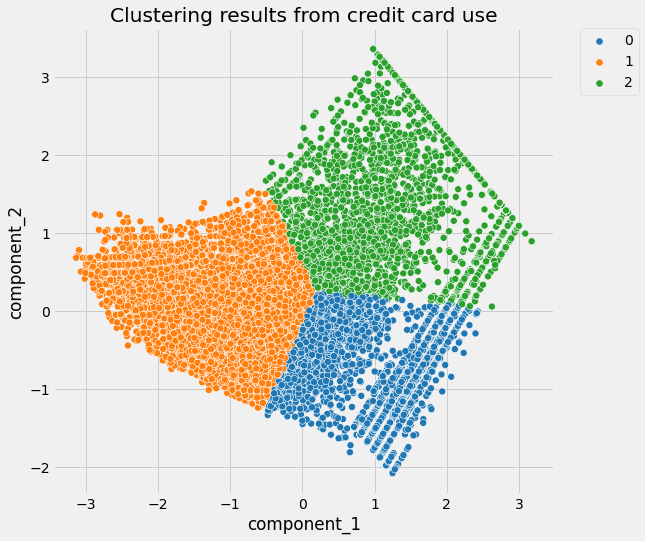

In [20]:
#plot the KMeans clusters
pcadf = pd.DataFrame(
        pipe["combined"].transform(features),
        columns=["component_1", "component_2"]
    )
   
pcadf["predicted_cluster"] = pipe['clusterer']['kmeans'].labels_

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
   
sp = sns.scatterplot(
        x="component_1", 
        y="component_2",
        s=50,
        data=pcadf,
        hue="predicted_cluster",
        palette='tab10'
    )
   
sp.set_title(
        "Clustering results from credit card use"
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
   
plt.show()